In [1]:
import numpy as np
from itertools import accumulate
from scipy.stats import norm
from scipy.stats import qmc
import scipy.stats as scs
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
S0 = 100.0
T = 2.0
sigma = 0.2
r = 0.05
N = 100
dt = T / N
B = np.random.randn(N)*np.sqrt(dt)

104.8023596165812 128.16226777638295


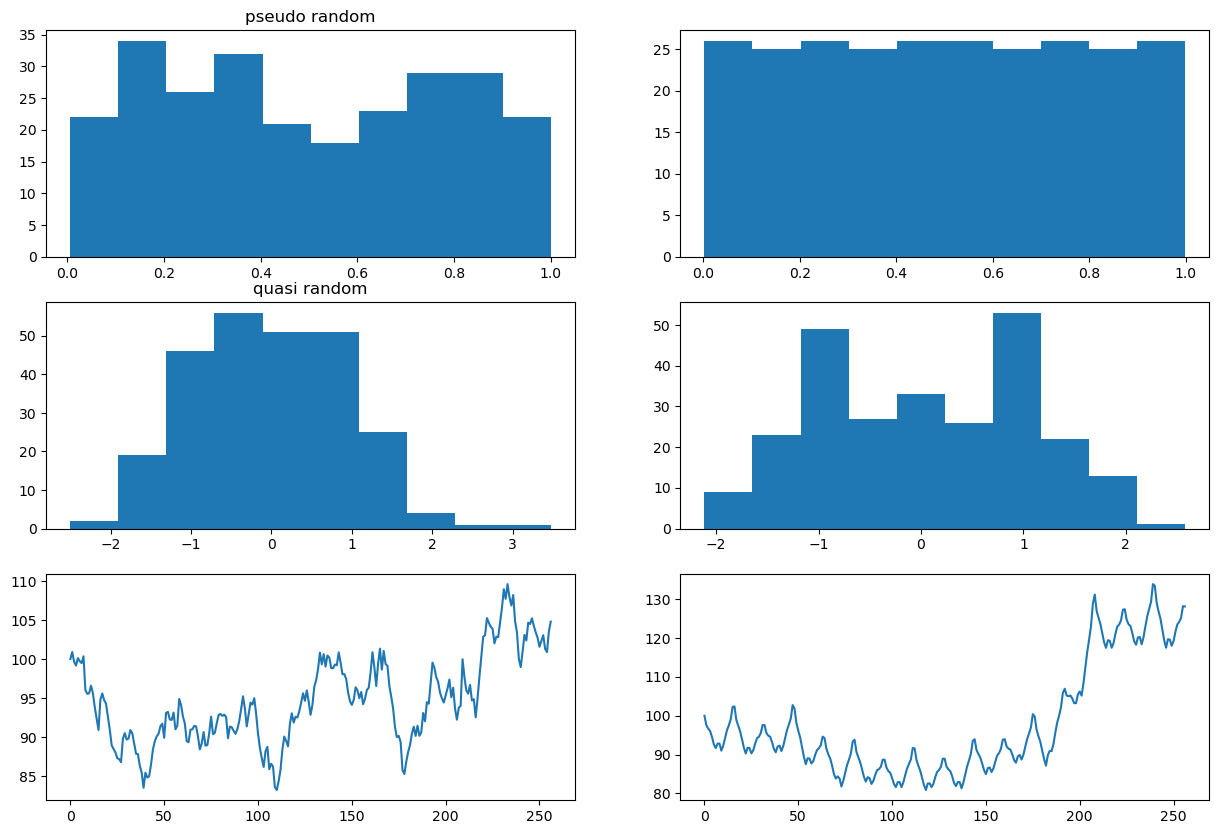

In [3]:
fig, axs = plt.subplots(3, 2, figsize=(15,10))

S0 = 100.0
T = 2.0
sigma = 0.2
r = 0.05
k = 8
N = 2**k
dt = T / N


punif = np.random.rand(N)
pnorm = norm.ppf(punif)
passet = list(accumulate(pnorm, lambda S,db: S * np.exp((r-0.5*sigma**2)*dt + sigma*db*np.sqrt(dt)), initial=S0))
axs[0,0].set_title('pseudo random')
axs[0,0].hist(punif)
axs[1,0].hist(pnorm)
axs[2,0].plot(passet)

sampler = qmc.Sobol(d=1, scramble=True)
#sampler.reset()
qunif = sampler.random_base2(m=k)
qnorm = norm.ppf(qunif).cumsum()
qasset = list(accumulate(qnorm, lambda S,db: S * np.exp((r-0.5*sigma**2)*dt + sigma*db*np.sqrt(dt)), initial=S0))
axs[1,0].set_title('quasi random')
axs[0,1].hist(qunif)
axs[1,1].hist(qnorm)
axs[2,1].plot(qasset);

print(passet[-1], qasset[-1])

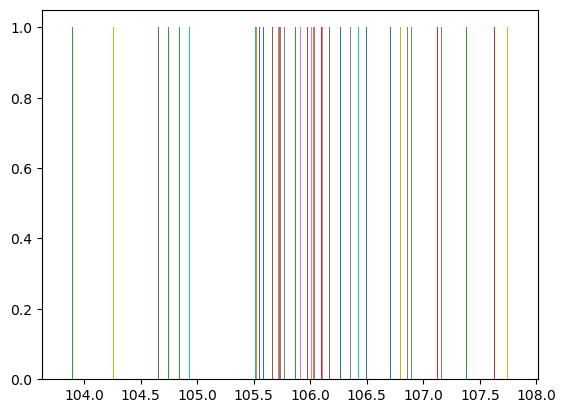

In [4]:
def get_qasset():
    S0 = 100.0
    T = 2.0
    sigma = 0.2
    r = 0.05
    k = 8
    N = 2**k
    dt = T / N
    sampler = qmc.Sobol(d=1, scramble=True)
    qunif = sampler.random_base2(m=k)
    qnorm = norm.ppf(qunif)
    qasset = list(accumulate(qnorm, lambda S,db: S * np.exp((r-0.5*sigma**2)*dt + sigma*db*np.sqrt(dt)), initial=S0))
    return qasset

ttt = [get_qasset()[-1] for i in range(100)]

plt.hist(ttt);

CPU times: total: 0 ns
Wall time: 0 ns


DescribeResult(nobs=64, minmax=(-2.2903183624202987, 2.5920340682656655), mean=0.0023298562725643235, variance=1.0030280313971662, skewness=0.04673382716382078, kurtosis=-0.17277016829016922)

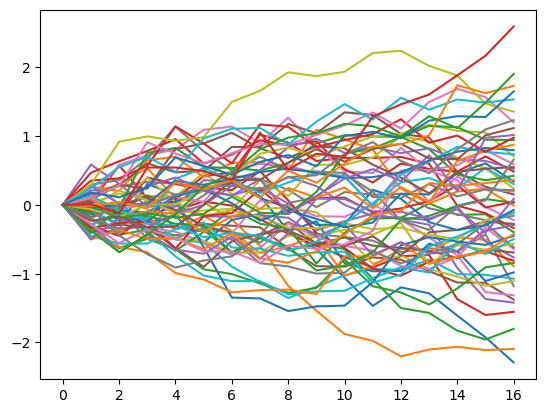

In [5]:
%time

def brownian_bridge(m, n, T=1.0):
    dt = T / n
    t = np.arange(0, T+dt, dt)
    total_paths = 2**m
    sampler = qmc.Sobol(d=1, scramble=True)
    W = np.zeros((total_paths,n+1))
    qunif = np.array(sampler.random_base2(m=m))[:, 0]
    qunif = (qunif + range(0,total_paths))/total_paths
    W[:,-1] = norm.ppf(qunif)*np.sqrt(t[-1])
    Z = np.random.standard_normal((total_paths, n-1))
    for j in range(1, n):
        lw = (t[n]-t[j])/(t[n]-t[j-1])
        rw = (t[j]-t[j-1])/(t[n]-t[j-1])
        stdev = ((t[n]-t[j])*(t[j]-t[j-1]))/(t[n]-t[j-1])
        W[:, j] = lw*W[:, j-1] + rw*W[:, n] + np.sqrt(stdev)*Z[:, j-1]
    return W

m = 6
n = 2**4
T = 1

Ws = brownian_bridge(m, n, T)

for w in Ws:
    plt.plot(w)

scs.describe(np.array(Ws)[:, -1])

CPU times: total: 0 ns
Wall time: 0 ns


DescribeResult(nobs=256, minmax=(-2.7575811049540997, 3.095651844905546), mean=0.000758322483906837, variance=1.0016951694857137, skewness=0.020211734772836037, kurtosis=-0.04471934647766185)

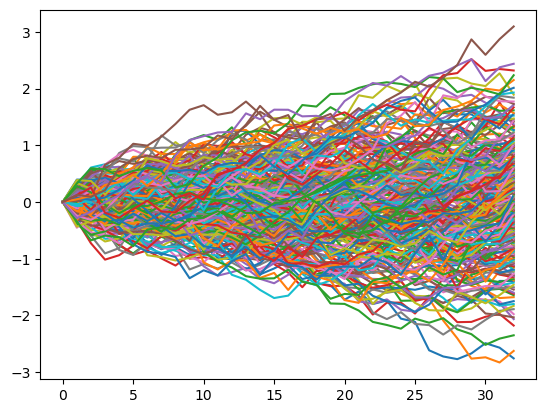

In [6]:
%time

def brownian_bridge(m, k, T):
    n = 2**k
    dt = T / n
    t = np.arange(0, T+dt, dt)
    total_paths = 2**m

    sampler = qmc.Sobol(d=1, scramble=True)
    qunif = np.array(sampler.random_base2(m=m))[:, 0]
    qunif = (qunif + range(0,total_paths))/total_paths

    W = np.zeros((total_paths,n+1))
    W[:,-1] = norm.ppf(qunif)*np.sqrt(t[-1])
    Z = np.random.standard_normal((total_paths, n-1))
    
    for i in range(0, k):
        h = 2**(k-i)
        for j in range(0, 2**i):
            a = j*h
            b = j*h+int(h/2)
            c = (j+1)*h
            lw = (t[c]-t[b])/(t[c]-t[a])
            rw = (t[b]-t[a])/(t[c]-t[a])
            stdev = ((t[c]-t[b])*(t[b]-t[a]))/(t[c]-t[a])
            W[:, b] = lw*W[:, a] + rw*W[:, c] + np.sqrt(stdev)*Z[:, b-1]
    return W

m = 8
k = 5
T = 1
Ws = brownian_bridge(m, k, T)

for w in Ws:
    plt.plot(w)

scs.describe(np.array(Ws)[:, -1])

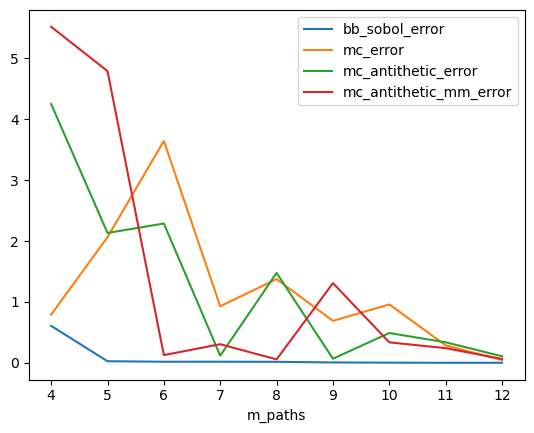

In [8]:
def BlackScholesMerton(S0, K, r, div, sigma, T):
    h1 = (np.log(S0 / K) + ((r - div) + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    h2 = h1 - sigma * np.sqrt(T)
    return S0 * np.exp(-div * T) * norm.cdf(h1) - K * np.exp(-r * T) * norm.cdf(h2)

def price_with_brownian_bridge(m):
    k = 0
    T = 1

    B = brownian_bridge(m, k, T)
    t = np.arange(0, T+T/2**k, T/2**k)
    paths = S0 * np.exp((r-0.5*sigma**2)*t + sigma*B)

    #fig, axs = plt.subplots(1, 2, figsize=(15,5))
    #for p in paths:
    #    axs[0].plot(t, p)
    #axs[1].hist(paths[:,-1], bins=30);

    return np.exp(-r*T)*np.mean(np.maximum(paths[:, -1] - K, 0))

def pricing_with_mc(m):
    z = np.random.standard_normal(2**m)
    S = S0 * np.exp((r-0.5*sigma**2)*T + sigma*z*np.sqrt(T))
    return np.exp(-r*T)*np.mean(np.maximum(S - K, 0))

def pricing_with_mc_antithetic(m):
    z = np.random.standard_normal(2**(m-1))
    z = np.concatenate((z,-z))
    S = S0 * np.exp((r-0.5*sigma**2)*T + sigma*np.random.standard_normal(2**m)*np.sqrt(T))
    return np.exp(-r*T)*np.mean(np.maximum(S - K, 0))

def pricing_with_mc_antithetic_mm(m):
    z = np.random.standard_normal(2**(m-1))
    z = np.concatenate((z,-z))
    z = (z-z.mean())/z.std()
    S = S0 * np.exp((r-0.5*sigma**2)*T + sigma*np.random.standard_normal(2**m)*np.sqrt(T))
    return np.exp(-r*T)*np.mean(np.maximum(S - K, 0))

S0 = 100.0 # pot at time zero
K = 100.0 # option strike
T = 1.0 # time to expiry
r = 0.05 # risk free rate
div = 0.00 # dividend yield
sigma = 0.2 # volatility

df = pd.DataFrame(data=list(range(4, 13)), columns=['m_paths'])
df['exact'] = BlackScholesMerton(S0=S0, K=K, r=r, div=div, sigma=sigma, T=T)
df['bb_sobol'] = df.m_paths.apply(lambda m: price_with_brownian_bridge(m))
df['mc'] = df.m_paths.apply(lambda m: pricing_with_mc(m))
df['mc_antithetic'] = df.m_paths.apply(lambda m: pricing_with_mc_antithetic(m))
df['mc_antithetic_mm'] = df.m_paths.apply(lambda m: pricing_with_mc_antithetic_mm(m))

methods = ['bb_sobol', 'mc', 'mc_antithetic', 'mc_antithetic_mm']
methods_error = [method+'_error' for method in methods]

for m, m_err in zip(methods, methods_error):
    df[m_err] = abs(df[m] - df['exact'])

df[['m_paths'] + methods_error].plot(x='m_paths');